# Introduction

This data analysis project is done using the Supermart Grocery Sales dataset. It is a generic dataset with around 10K entries and 11 columns, and is meant to be used as a practice dataset.

# Objectives
The objectives of the project is to 
- perform exploratory data analysis to discover any insights and patterns,
- Find out if there are any products that are performing above/below average and if it is statistically significant


The main parts of this project consists of: 
- data pre-processing steps
- exploratory data analysis
- margin analysis with hypothesis testing

## Project Setup

In [3]:
# Importing libraries and packages required for analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.stats.weightstats import ztest
from scipy.stats import linregress

#File path
filepath = '../input/supermart-grocery-sales-retail-analytics-dataset/Supermart Grocery Sales - Retail Analytics Dataset.csv'


In [5]:
# Pandas and Seaborn options
pd.set_option('display.float_format', '{:0.4f}'.format)

sns.set_style('whitegrid')
sns.set_palette('muted')

# Data pre-processing


## Loading Data

In [7]:
# Loading data into sgs(supermart grocery sales) dataframe
df = pd.read_csv(filepath)

print(df.shape)
df.head()

(9994, 11)


,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State
0,OD1,Harish,Oil & Masala,Masalas,Vellore,11-08-2017,North,1254,0.1200,401.2800,Tamil Nadu
1,OD2,Sudha,Beverages,Health Drinks,Krishnagiri,11-08-2017,South,749,0.1800,149.8000,Tamil Nadu
2,OD3,Hussain,Food Grains,Atta & Flour,Perambalur,06-12-2017,West,2360,0.2100,165.2000,Tamil Nadu
3,OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,10-11-2016,South,896,0.2500,89.6000,Tamil Nadu
4,OD5,Ridhesh,Food Grains,Organic Staples,Ooty,10-11-2016,South,2355,0.2600,918.4500,Tamil Nadu


Previewing the dataset shows that there are 9994 entries with 11 columns. 

There is the Order ID column which is the primary key. 
Customer Name column that records the customer that made the purchase

For categorical columns ,there are the [category, sub category, city, region, state]columns that has some detail about each individual order.

There is a Order Date column recording the dates of the order, and finally there is the numerical cols like [Sales, Discount and Profit]

## Data Cleaning

There are a few things that needs to be checked and done before the analysis can proceed.
1. Renaming columns to eliminate empty space in between column names
2. Validating that columns have the appropriate data type
3. Check and remove N/A values or duplicated values if any
4. Check for anomalies in categorical and numerical columns (typo errors, values that don't make sense, etc.)

### Renaming Columns for easier access

In [8]:
rename_dict = {'Order ID':'order_id',
               'Customer Name':'customer_name',
               'Category':'category',
               'Sub Category':'sub_category',
               'City':'city',
               'Order Date':'order_date',
               'Region':'region',
               'Sales':'sale_price',
               'Discount':'discount',
               'Profit':'profit',
               'State':'state'
              }

df = df.rename(columns=rename_dict).copy()

### Validating the datatype of each column

Checking the datatypes of the resepective columns.

In [9]:
for col in df.columns:
    print(col + ' has the datatype: \t',  df[col].dtype)

order_id has the datatype: 	 object
customer_name has the datatype: 	 object
category has the datatype: 	 object
sub_category has the datatype: 	 object
city has the datatype: 	 object
order_date has the datatype: 	 object
region has the datatype: 	 object
sale_price has the datatype: 	 int64
discount has the datatype: 	 float64
profit has the datatype: 	 float64
state has the datatype: 	 object


Looking at the results, the order date is not recognised as a datetime object. It needs to be converted to a datetime object column.

From experience, the month and year data might be useful as well. It will be extracted into its own column for easier access.

In [11]:
# Converting order_date to datetime datatype
df['order_date'] = pd.to_datetime(df['order_date'])

df['year'] = df['order_date'].apply(lambda x : x.year)
df['month'] = df['order_date'].apply(lambda x : x.month)

### Checking for N/A and duplicate values

In [12]:
df.isna().all()

order_id         False
customer_name    False
category         False
sub_category     False
city             False
order_date       False
region           False
sale_price       False
discount         False
profit           False
state            False
year             False
month            False
dtype: bool

In [13]:
df.duplicated().sum()

0

### Checking for weird values or any error in data

First, the categorical columns are checked. Histograms for the columns were plotted for easier inspection

In [14]:
categorical_columns = ['category','sub_category','city','region', 'state']

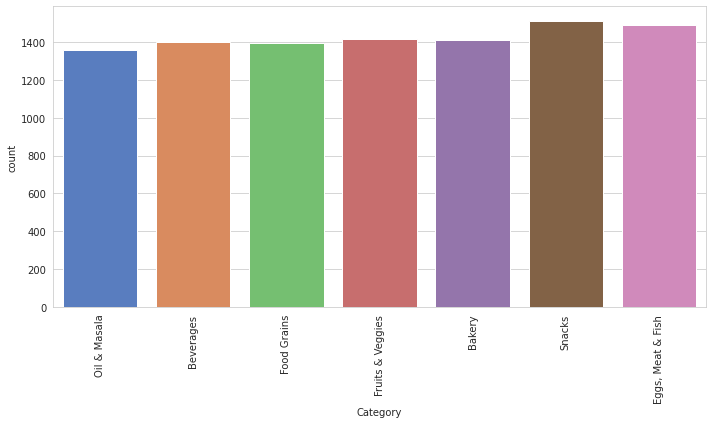

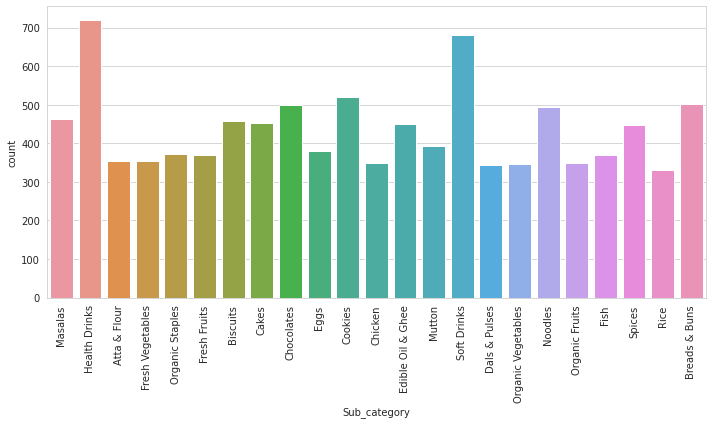

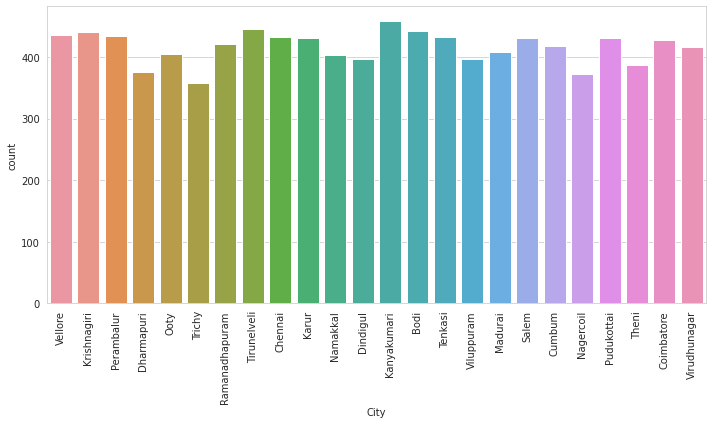

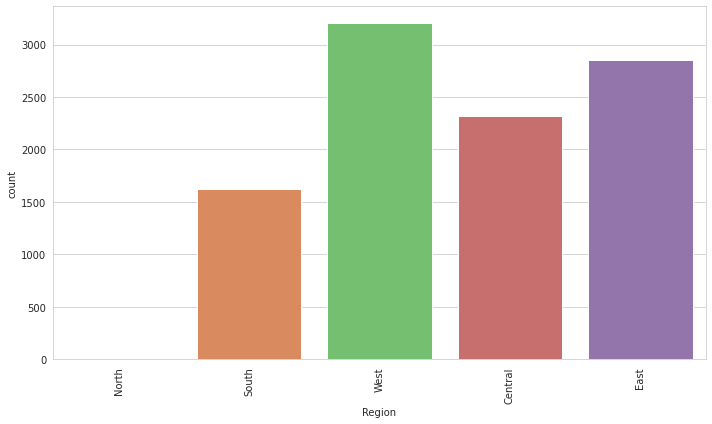

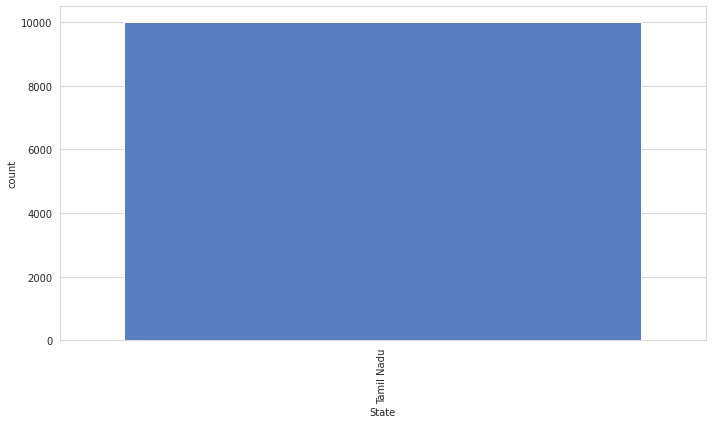

In [15]:
def plot_all_hist(df, columns):
    for col in columns:
        plt.figure(figsize=(10,6))
        sns.countplot(x=col, data=df)
        plt.xlabel(col.capitalize())
        plt.xticks(rotation='90')
        plt.tight_layout()
        plt.show()

plot_all_hist(df, categorical_columns)

In [16]:
df.region.value_counts()

West       3203
East       2848
Central    2323
South      1619
North         1
Name: region, dtype: int64

From the histograms, the findings are:
1. Region column - there is only one row of data for the north region. Considering the fact that it is only one column, it is safe to drop it without much concern of loss of data. 
2. The State column contains exclusively one value, which is "Tamil Nadu". This might be a dataset that is filtered by this state in the first place. Considering this, it is safe to drop the entire column as it won't be helpful in the analysis.

In [17]:
# Removing the state column
sgs =df.drop(columns=['state']).copy()

# Removing the row of data that contains region == North
index_to_remove = sgs[sgs.region == 'North'].index.values
sgs = sgs.drop(index = index_to_remove).copy()

In [18]:
# Vallidating that the "North" entry has been removed

print(sgs.columns)
print("")
print(sgs.region.value_counts())

Index(['order_id', 'customer_name', 'category', 'sub_category', 'city',
       'order_date', 'region', 'sale_price', 'discount', 'profit', 'year',
       'month'],
      dtype='object')

West       3203
East       2848
Central    2323
South      1619
Name: region, dtype: int64


### Checking numerical columns anomalies

The main purpose is to check if the columns contains any negative value. It is fine for the columns to contain negative value, it would mean that the order's are incurring losses, but it would be a good check to understand the data more.

In [19]:
numerical_cols = ['sale_price','discount','profit']

In [20]:
sgs[numerical_cols].describe()

,sale_price,discount,profit
count,9993.0000,9993.0000,9993.0000
mean,1496.6204,0.2268,374.9344
std,577.5828,0.0746,239.9447
min,500.0000,0.1000,25.2500
25%,1000.0000,0.1600,180.0000
50%,1498.0000,0.2300,320.7600
75%,1995.0000,0.2900,525.6900
max,2500.0000,0.3500,1120.9500


It looks like there were no losses for the orders as the profit column is non-negative. With this, the data cleaning and validation process is done.

## Adding Features

During the cleaning process, I noticed that there is a column with the discount percentage. To better make use of the discount percentage, we should get the original price and the discounted amount by performing some simple transformations.

In [21]:
sgs['original_price'] = sgs['sale_price']/(1- sgs['discount'])
sgs['discount_amount'] = sgs['original_price'] - sgs['sale_price']
sgs.head()

,order_id,customer_name,category,sub_category,city,order_date,region,sale_price,discount,profit,year,month,original_price,discount_amount
1,OD2,Sudha,Beverages,Health Drinks,Krishnagiri,2017-11-08,South,749,0.1800,149.8000,2017,11,913.4146,164.4146
2,OD3,Hussain,Food Grains,Atta & Flour,Perambalur,2017-06-12,West,2360,0.2100,165.2000,2017,6,2987.3418,627.3418
3,OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,2016-10-11,South,896,0.2500,89.6000,2016,10,1194.6667,298.6667
4,OD5,Ridhesh,Food Grains,Organic Staples,Ooty,2016-10-11,South,2355,0.2600,918.4500,2016,10,3182.4324,827.4324
5,OD6,Adavan,Food Grains,Organic Staples,Dharmapuri,2015-06-09,West,2305,0.2600,322.7000,2015,6,3114.8649,809.8649


The data pre-processing is done for now. The following cleaning steps are carried out:
1. The data columns are renamed, 
2. data types are validated, 
3. N/A and duplicated values are checked. 
4. Attempts to check for errors and anomalies

Other than that, new features such as the original price, discount amount, and month/year data is also added.
Let us proceed with the analysis.


In [22]:
sgs.head()

,order_id,customer_name,category,sub_category,city,order_date,region,sale_price,discount,profit,year,month,original_price,discount_amount
1,OD2,Sudha,Beverages,Health Drinks,Krishnagiri,2017-11-08,South,749,0.1800,149.8000,2017,11,913.4146,164.4146
2,OD3,Hussain,Food Grains,Atta & Flour,Perambalur,2017-06-12,West,2360,0.2100,165.2000,2017,6,2987.3418,627.3418
3,OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,2016-10-11,South,896,0.2500,89.6000,2016,10,1194.6667,298.6667
4,OD5,Ridhesh,Food Grains,Organic Staples,Ooty,2016-10-11,South,2355,0.2600,918.4500,2016,10,3182.4324,827.4324
5,OD6,Adavan,Food Grains,Organic Staples,Dharmapuri,2015-06-09,West,2305,0.2600,322.7000,2015,6,3114.8649,809.8649


# Exploratory Data Analysis

This analysis section is an exploratory section that uncovers some descriptive statistics about the dataset.

The features to explore:
- Sale Price , Profit and Discount amount distribution
- Sales amount and Sale count by year and month
- Relationship between profit and discount amount

## Sale Price, Profit and Discount amount distribution

Let's start by taking a look at the statistics of the numerical columns and it's histogram

In [25]:
def plot_num_histogram(columns):
    for col in columns:  
        print(f'The stats for {col} are as follows:')
        print(sgs[columns].describe())
        print("")
        print(f'The histogram for {col} is shown below:')
        plt.figure(figsize=(10,6))
        plt.hist(sgs[col], bins=20)
        plt.title(col.capitalize() + " Distribution")
        plt.xlabel(col.capitalize())
        plt.ylabel('Count')
        plt.axvline(sgs[col].mean(), color='red', linestyle='dashed', linewidth=3, label='mean = ' + "{:.2f}".format(sgs[col].mean()))
        plt.axvline(sgs[col].median(), color='green', linestyle='dashdot', linewidth=3, label='median = '+ "{:.2f}".format(sgs[col].median()))
        plt.legend()
        plt.show()
        print('')
        

The stats for sale_price are as follows:
       sale_price    profit  discount_amount
count   9993.0000 9993.0000        9993.0000
mean    1496.6204  374.9344         456.8789
std      577.5828  239.9447         268.2104
min      500.0000   25.2500          55.6667
25%     1000.0000  180.0000         246.1395
50%     1498.0000  320.7600         398.2963
75%     1995.0000  525.6900         619.1026
max     2500.0000 1120.9500        1345.6154

The histogram for sale_price is shown below:


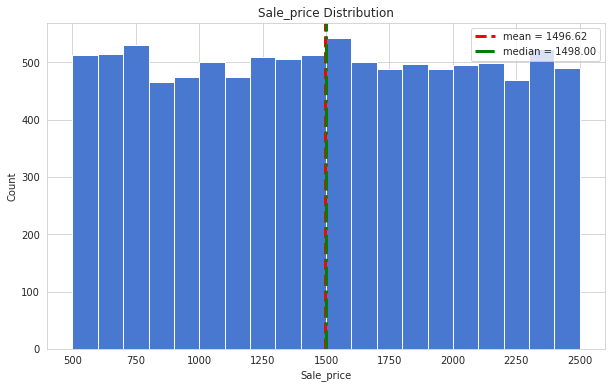


The stats for profit are as follows:
       sale_price    profit  discount_amount
count   9993.0000 9993.0000        9993.0000
mean    1496.6204  374.9344         456.8789
std      577.5828  239.9447         268.2104
min      500.0000   25.2500          55.6667
25%     1000.0000  180.0000         246.1395
50%     1498.0000  320.7600         398.2963
75%     1995.0000  525.6900         619.1026
max     2500.0000 1120.9500        1345.6154

The histogram for profit is shown below:


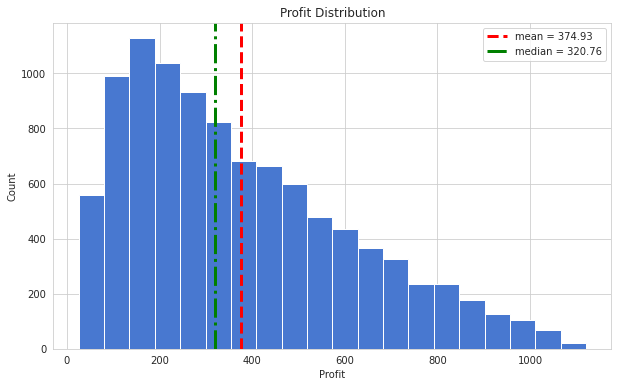


The stats for discount_amount are as follows:
       sale_price    profit  discount_amount
count   9993.0000 9993.0000        9993.0000
mean    1496.6204  374.9344         456.8789
std      577.5828  239.9447         268.2104
min      500.0000   25.2500          55.6667
25%     1000.0000  180.0000         246.1395
50%     1498.0000  320.7600         398.2963
75%     1995.0000  525.6900         619.1026
max     2500.0000 1120.9500        1345.6154

The histogram for discount_amount is shown below:


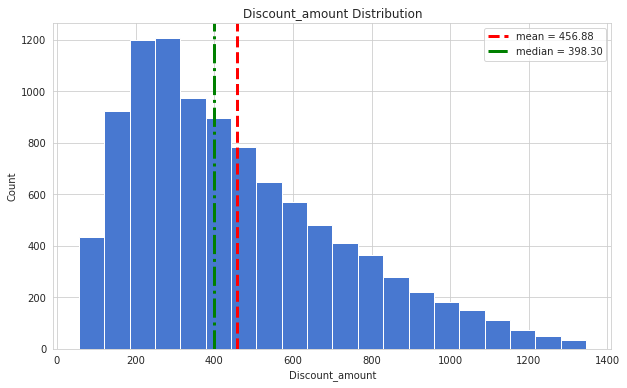

In [26]:
plot_num_histogram(['sale_price', 'profit', 'discount_amount'])

From the data, the following findings can be observed:

 - The sale price distribution is uniform, while for both the discount amount and the total profit it is right skewed. This means that:
     - There are a variety of sale prices catering to various levels of purchasing power
     - There are much less instances where there is huge profit or huge discount per order
 - The mean sale price is 1496.62, while the median for the profit and discount amount is 320.75 and 398.30 respectively.
 
## Sales amount and Sale count by year and month

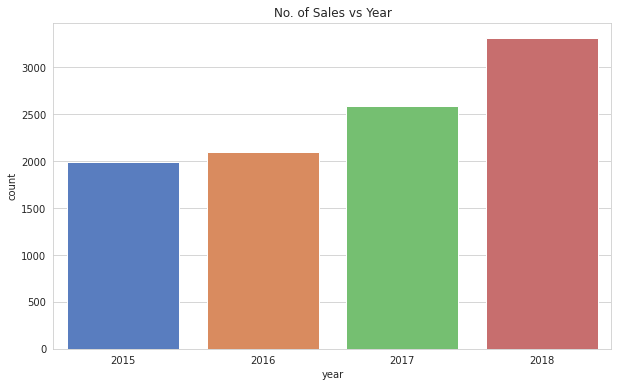

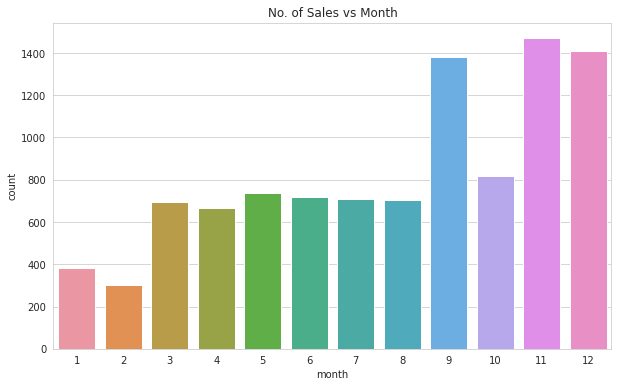

In [27]:
plt.figure(figsize=(10,6))
sns.countplot(data=sgs, x='year')
plt.title('No. of Sales vs Year')
plt.show()

plt.figure(figsize=(10,6))
sns.countplot(data=sgs, x='month')
plt.title('No. of Sales vs Month')
plt.show()

From the two plots, we are able to make the following observations:
1. There is an increasing trend in the no of sale made per year
2. There is a significantly more amount of purchase made during September, November and December, and much less purchases during January and February.

However this is only the no. of sales, let's take a look at the sales amount and profit over time.

In [28]:
sgs_grouped_by_year = sgs.groupby('year', as_index=False).agg(sale_amount = pd.NamedAgg(column='sale_price', aggfunc='sum'),
                                                             profit_amount = pd.NamedAgg(column='profit', aggfunc='sum'))
sgs_grouped_by_month = sgs.groupby('month', as_index=False).agg(sale_amount = pd.NamedAgg(column='sale_price', aggfunc='sum'),
                                                               profit_amount = pd.NamedAgg(column='profit', aggfunc='sum'))

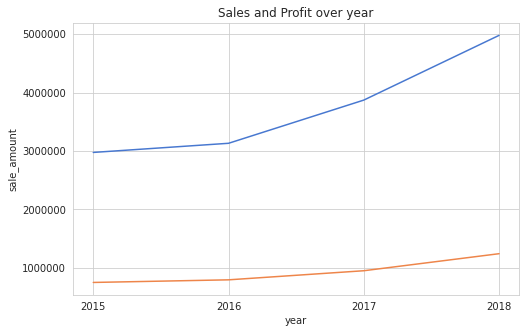

In [29]:
plt.figure(figsize=(8,5))
sns.lineplot(data=sgs_grouped_by_year, x='year', y='sale_amount')
sns.lineplot(data=sgs_grouped_by_year, x='year', y='profit_amount')
plt.xticks(ticks=[2015,2016,2017,2018])
plt.ticklabel_format(style='plain')
plt.title('Sales and Profit over year')
plt.show()

As shown from the plot, it can be seen that the sales amount and profit does increase over the year, however the profit amount is not increasing as much as the sale amount. Let's take a closer look by plotting it in terms of months.

In [30]:
sgs_grouped_by_YM = sgs.groupby(['year','month'], as_index=False).agg(sale_amount = pd.NamedAgg(column='sale_price', aggfunc='sum'),
                                                               profit_amount = pd.NamedAgg(column='profit', aggfunc='sum'),
                                                                     sale_count = pd.NamedAgg(column='profit', aggfunc='count'))

sgs_grouped_by_YM['date'] = np.array(sgs_grouped_by_YM['year'].astype('str') +'-'+ sgs_grouped_by_YM ['month'].astype('str') + '-1', dtype=datetime.date)

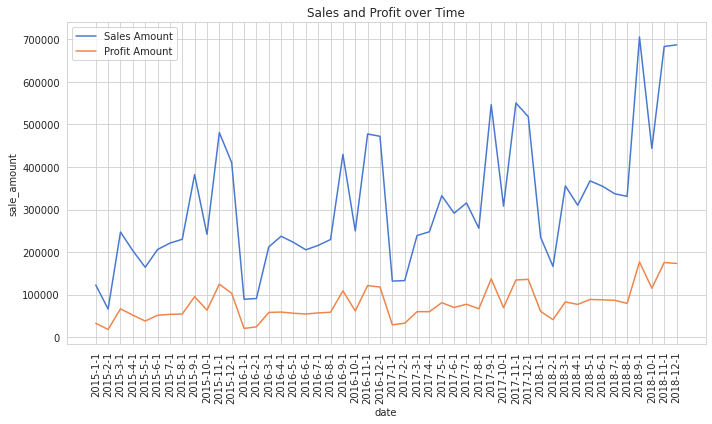

In [31]:
plt.figure(figsize=(10,6))
sns.lineplot(data=sgs_grouped_by_YM, x='date', y='sale_amount', label='Sales Amount')
sns.lineplot(data=sgs_grouped_by_YM, x='date', y='profit_amount', label='Profit Amount')
# sns.lineplot(data=sgs_grouped_by_YM, x='date', y='sale_count', label='Sale Count')

plt.legend()
# plt.xticks(ticks=[2015,2016,2017,2018])
plt.xticks(rotation=90)
plt.title('Sales and Profit over Time')
plt.tight_layout()
plt.show()

Here it can be observed that there is a bit of fluctuation. The fluctuation is caused by the findings on the previous section, there was more sales nearing November and December, and less during January and February. 

Let's try to smoothen the plot a bit by using the moving average instead.

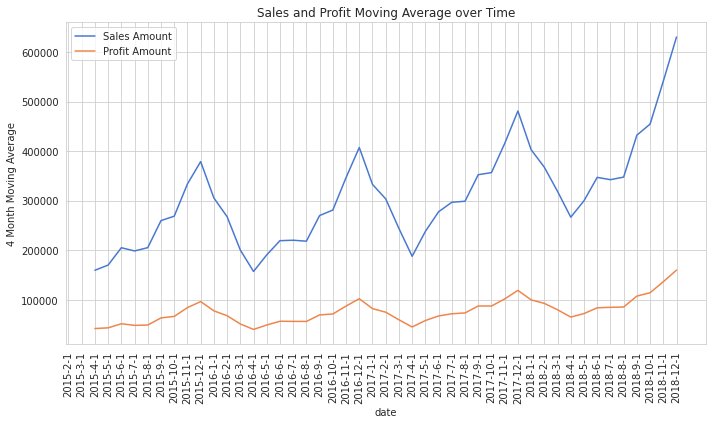

In [32]:
# Plotting using 4 month - Moving Average 
sgs_grouped_by_YM['sale_MA'] = sgs_grouped_by_YM['sale_amount'].rolling(4).mean()
sgs_grouped_by_YM['profit_MA'] = sgs_grouped_by_YM['profit_amount'].rolling(4).mean()

# Plotting
plt.figure(figsize=(10,6))
sns.lineplot(data=sgs_grouped_by_YM, x='date', y='sale_MA', label='Sales Amount')
sns.lineplot(data=sgs_grouped_by_YM, x='date', y='profit_MA', label='Profit Amount')
plt.legend()
plt.xticks(rotation=90)
plt.ylabel('4 Month Moving Average')
plt.title('Sales and Profit Moving Average over Time')
plt.tight_layout()
plt.show()


The visualization is now smoothen, but still retaining enough amount of data that to show that we experience dips during the start of the year and highs during the later parts of the year.

## Relationship between sales, profit and discount

Now that we know the general trend of sales, profit and sale count is increasing, let's explore if there is any strong correlation between sales, profit and discount amount.

A good way of exploring the correlation between these variables is to use a heat map from the seaborn library.

In [33]:
sgs.columns

Index(['order_id', 'customer_name', 'category', 'sub_category', 'city',
       'order_date', 'region', 'sale_price', 'discount', 'profit', 'year',
       'month', 'original_price', 'discount_amount'],
      dtype='object')

<AxesSubplot:>

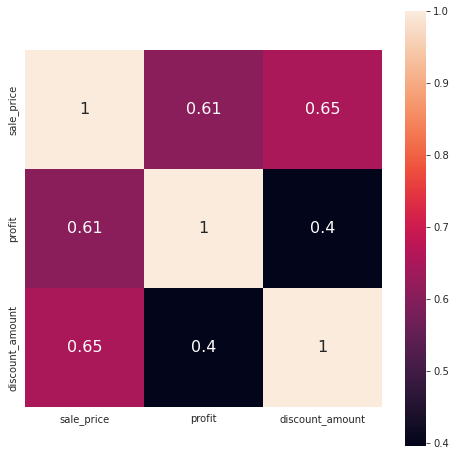

In [34]:
plt.figure(figsize=(8,8))
sns.heatmap(sgs[['sale_price','profit','discount_amount']].corr(), square=True, annot=True, annot_kws={"size":16})

We can see that:
- Between Profit and Discount amount, the correlation value is 0.4
- Between Profit and Sale Price, the correlation value is 0.61

Let's continue the analysis by looking at a scatterplot to see the relationship between the two variables.

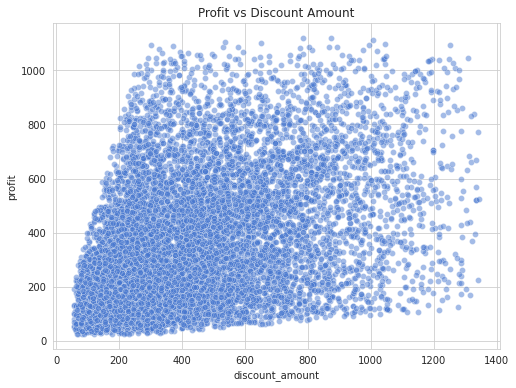

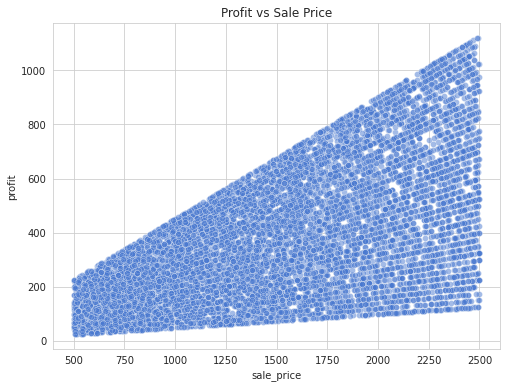

In [35]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=sgs, y='profit', x='discount_amount', alpha=0.5)
plt.title('Profit vs Discount Amount')
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(data=sgs, y='profit', x='sale_price', alpha=0.5, y_jitter=True, x_jitter=True)
plt.title('Profit vs Sale Price')
plt.show()

As we know from the correlation data, there is a positive correlation for both of the relationships. Let's take a look at the slope for linear regression before we end this section of analysis.

In [36]:
res = linregress(sgs['sale_price'], sgs['profit'])
print(res.slope)

0.25148372151464227


In [37]:
res = linregress(sgs['discount_amount'], sgs['profit'])
print(res.slope)

0.3539652446669727


The slope value for both sale price and discount amount is around 0.25~0.35. This means that considering the variables indepedently, there is an increase of 0.25/0.35 per unit increase in sale price or discount amount respectively.

## Takeaway from EDA
Here are the findings from the EDA section:
- The sale price of items are uniformly distributed, while the profit and discount amount is a right skewed distribution.
- An increasing trend over time in the sales count, sales amount and profit was observed
- A pattern was observed when the orders were categorized by months,
    - There are higher amount of sales in the months September, November and December
    - There are lower amount of sales in the months January and February
- A certain level of positive correlation exists when examining the profit against the sale price(corr = 0.25) and the discount amount (corr = 0.35)

# Margin Analysis -  by order category

This section is a deeper dive into the dataset by categorizing the orders using the 'category' and 'sub-category' columns. After grouping, the better and worse performing groups are chosen to analyze.

In [38]:
sgs_groupedby_category = sgs.groupby('category')[['sale_price','profit']].agg(sale_count = pd.NamedAgg(column='sale_price', aggfunc='count'),
                                                                        sale_total=pd.NamedAgg(column="sale_price", aggfunc="sum"),
                                                                        profit_total=pd.NamedAgg(column="profit", aggfunc="sum"))

sgs_groupedby_category['margin'] = sgs_groupedby_category['profit_total']/sgs_groupedby_category['sale_total']
sgs_groupedby_category['profit_per_order'] = sgs_groupedby_category['profit_total']/sgs_groupedby_category['sale_count']
sgs_groupedby_category

,sale_count,sale_total,profit_total,margin,profit_per_order
category,,,,,
Bakery,1413,2112281,528521.0600,0.2502,374.0418
Beverages,1400,2085313,525605.7600,0.2521,375.4327
"Eggs, Meat & Fish",1490,2267401,567357.2200,0.2502,380.7767
Food Grains,1398,2115272,529162.6400,0.2502,378.5140
Fruits & Veggies,1418,2100727,530400.3800,0.2525,374.0482
Oil & Masala,1360,2037188,497494.0100,0.2442,365.8044
Snacks,1514,2237546,568178.8500,0.2539,375.2833


As can be seen from the summarized data, the data is very uniform and there is but a little variance in all of the columns. We can check the standard deviation to verify this.

In [39]:
sgs_groupedby_category.describe()

,sale_count,sale_total,profit_total,margin,profit_per_order
count,7.0000,7.0000,7.0000,7.0000,7.0000
mean,1427.5714,2136532.5714,535245.7029,0.2505,374.8430
std,54.5767,83810.5366,24965.1829,0.0031,4.6939
min,1360.0000,2037188.0000,497494.0100,0.2442,365.8044
25%,1399.0000,2093020.0000,527063.4100,0.2502,374.0450
50%,1413.0000,2112281.0000,529162.6400,0.2502,375.2833
75%,1454.0000,2176409.0000,548878.8000,0.2523,376.9734
max,1514.0000,2267401.0000,568178.8500,0.2539,380.7767


In [40]:
# Std as percentage of mean
sgs_groupedby_category.std()/sgs_groupedby_category.mean()*100

sale_count         3.8230
sale_total         3.9227
profit_total       4.6642
margin             1.2411
profit_per_order   1.2522
dtype: float64

As seen from above, the standard deviation for each category is relatively small(<5%) within it's own category. Hence, the analysis was extended to look at the sub categories instead of looking only at the main category.

In [41]:
sgs_groupedby_sub_category = sgs.groupby(['category', 'sub_category'], as_index=False)[['sale_price','profit']].agg(sale_count = pd.NamedAgg(column='sale_price', aggfunc='count'),
                                                                                       sale_total=pd.NamedAgg(column="sale_price", aggfunc="sum"),
                                                                                       profit_total=pd.NamedAgg(column="profit", aggfunc="sum"))

sgs_groupedby_sub_category['margin'] = sgs_groupedby_sub_category['profit_total']/sgs_groupedby_sub_category['sale_total']
sgs_groupedby_sub_category['profit_per_order'] = sgs_groupedby_sub_category['profit_total']/sgs_groupedby_sub_category['sale_count']

sgs_groupedby_sub_category

,category,sub_category,sale_count,sale_total,profit_total,margin,profit_per_order
0,Bakery,Biscuits,459,684083,169357.6200,0.2476,368.9708
1,Bakery,Breads & Buns,502,742586,190764.9800,0.2569,380.0099
2,Bakery,Cakes,452,685612,168398.4600,0.2456,372.5630
3,Beverages,Health Drinks,719,1051439,267469.7900,0.2544,372.0025
4,Beverages,Soft Drinks,681,1033874,258135.9700,0.2497,379.0543
5,"Eggs, Meat & Fish",Chicken,348,520497,124049.8900,0.2383,356.4652
6,"Eggs, Meat & Fish",Eggs,379,575156,144669.9200,0.2515,381.7148
7,"Eggs, Meat & Fish",Fish,369,560548,147248.0100,0.2627,399.0461
8,"Eggs, Meat & Fish",Mutton,394,611200,151389.4000,0.2477,384.2371
9,Food Grains,Atta & Flour,353,534649,127861.1000,0.2391,362.2127


In [42]:
sgs_groupedby_sub_category.describe()

,sale_count,sale_total,profit_total,margin,profit_per_order
count,23.0000,23.0000,23.0000,23.0000,23.0000
mean,434.4783,650249.0435,162900.8661,0.2505,375.1571
std,103.5119,151781.5300,38684.7789,0.0073,10.7604
min,330.0000,498323.0000,124049.8900,0.2382,356.4652
25%,353.5000,530245.5000,132434.8500,0.2466,367.5290
50%,394.0000,611200.0000,151389.4000,0.2497,373.8217
75%,478.5000,715062.0000,176603.4800,0.2558,382.9759
max,719.0000,1051439.0000,267469.7900,0.2634,399.0461


In [43]:
# Std as percentage of mean
sgs_groupedby_sub_category.std(numeric_only=True)/sgs_groupedby_sub_category.mean(numeric_only=True)*100

sale_count         23.8244
sale_total         23.3421
profit_total       23.7474
margin              2.9001
profit_per_order    2.8682
dtype: float64

After grouping the data by sub category, it seems that the data seems to have a bit more variation as compared to just grouping by the main categories. There are a few points of interest to explore here with regards to the margin,which is
1. The sub-categories with the max sale count, total profit and profit per order
2. The sub-categories with the min amount for the same columns above


Let's start at the max end of the spectrum. 

The logic that is used for extracting the max and min data is similar, so a function is prepared to make multiple calls easier.

In [44]:
def get_extreme_category(df, target_col, get_max = True):
    if get_max:
        idx = df[target_col].idxmax()
        description = 'highest'
    else:
        idx = df[target_col].idxmin()
        description = 'lowest'
    sub_category = df.loc[idx, 'sub_category']
    main_category = df.loc[idx, 'category']
    print(f'The sub category with the {description} {target_col} is {sub_category} from {main_category} main category')

interest_cols =  ['sale_count', 'profit_total', 'profit_per_order']

In [47]:
# Getting higher end of categories
for col in interest_cols:
    get_extreme_category(sgs_groupedby_sub_category, col)
    
print("")

# Getting lower end of categories
for col in interest_cols:
    get_extreme_category(sgs_groupedby_sub_category, col, get_max=False)

The sub category with the highest sale_count is Health Drinks from Beverages main category
The sub category with the highest profit_total is Health Drinks from Beverages main category
The sub category with the highest profit_per_order is Fish from Eggs, Meat & Fish main category

The sub category with the lowest sale_count is Rice from Food Grains main category
The sub category with the lowest profit_total is Chicken from Eggs, Meat & Fish main category
The sub category with the lowest profit_per_order is Chicken from Eggs, Meat & Fish main category


From the results, the highest no. of sales and total profit is from the "Health Drinks" sub category, and highest profit per order is from the "Fish" sub category.

On the other hand, the "Rice" sub category has the lowest no. of sales, and "Chicken" has the lowest total profit and profit per order.

Let's take a closer look at these 4 sub categories.

In [48]:
print(f"The average no of sales per sub category is {int(sgs.sub_category.value_counts().mean())}")

The average no of sales per sub category is 434


From this summarized table, it can be seen that although the Health Drinks category has the highest sale count, and also having a relatively high profit per for order. Both the sales amount and high profit per order contributed to the health drinks category having the highest total profit out of all products.

Other than that, looking at the Fish sub category, although it has lower than average(434 as shown above) no of sales, it is able to have higher total profit thanks to having the highest profit per order at almost 400.

As for the Rice sub category, the profit per order is actually not low, at 384 per order, however there is a low amount of sales and hence it has lower overall profit. 

Lastly, looking at the chiken sub category, it suffers from both lower no of sales and profit per order, hence it is not surprising that it has lower overall profit as well.

## Hypothesis Testing

---
Update: I noticed that I have not checked the normality and homoscadasticity of the samples, so do bear that in mind when trying to repeat any hypothesis testing that is performed below.

2022/06/29

---


Although it can be seen that the filtered categories do perform better/worse in certain ways, it is hard to determine if it is by random chance. A hypothesis testing can be carried out to verify this.

Let's test the if the Health Drinks category do actually perform better than the other sub categories.

Assume:
1.  Significance level, alpha = 0.05
2. Hypothesis
- H0 = The means of the profit for Health Drinks and Non-Health Drinks are the same
- H1 = The means of the profit for Health Drinks is larger than Non-Health Drinks

We will use statsmodels package to help calculate the p-value for a right-tailed test, as we are concerned if the Health Drink profit mean is larger than the other mean.

In [49]:
health_drink_profit = sgs[sgs.sub_category.isin(['Health Drinks'])]['profit']
non_health_drink_profit = sgs[~sgs.sub_category.isin(['Health Drinks'])]['profit']

In [50]:
z_score, p_value =  ztest(health_drink_profit, non_health_drink_profit, alternative='larger')
print(z_score, p_value)

-0.3400994381020254 0.6331091775437484


From the calculation, the p-value is very much larger than alpha=0.05. Hence, we fail to reject the null hypothesis and this means that the Health Drink category is performing well by chance.

Let's repeat this for the other 3 categories as well.

In [52]:
def z_score_testing(sub_category, parameter='profit', test_side='two-sided', alpha=0.05):
    df_test = sgs[sgs.sub_category.isin([sub_category])][parameter]
    df_other = sgs[~sgs.sub_category.isin([sub_category])][parameter]
    z_score, p_value = ztest(df_test, df_other, alternative=test_side)
    print(f"For {sub_category} sub category, the z-score is {z_score}, and the p-value is {p_value}.")
    if p_value > alpha:
        print(f"The p-value is larger than alpha={alpha}, we fail to reject the null hypothesis.")
    else:
        print(f"The p-value is smaller than alpha={alpha}, we reject the null hypothesis.")

In [53]:
z_score_testing('Fish',test_side='larger')
print("")
z_score_testing('Rice',test_side='smaller')
print("")
z_score_testing('Chicken', test_side='smaller')

For Fish sub category, the z-score is 1.967258373826087, and the p-value is 0.02457671567888886.
The p-value is smaller than alpha=0.05, we reject the null hypothesis.

For Rice sub category, the z-score is 0.7474905128954339, and the p-value is 0.7726162363106105.
The p-value is larger than alpha=0.05, we fail to reject the null hypothesis.

For Chicken sub category, the z-score is -1.461669043979401, and the p-value is 0.07191596204347718.
The p-value is larger than alpha=0.05, we fail to reject the null hypothesis.


From our results, it can be seen that only for the Fish sub category there is established statistical significance. This means that the Fish category is performing well not because of chance.

Other than that the Rice and Chicken sub category are performing worse by chance, as they both have higher than 0.05 p-value.

# Conclusion

The findings that was obtained from performing the EDA and the margin analysis is as such:
- The sale price of items are uniformly distributed, while the profit and discount amount is a right skewed distribution.
- An increasing trend over time in the sales count, sales amount and profit was observed
- A pattern was observed when the orders were categorized by months,
    - There are higher amount of sales in the months September, November and December
    - There are lower amount of sales in the months January and February
- A certain level of positive correlation exists when examining the profit against the sale price(corr = 0.25) and the discount amount (corr = 0.35)
- By grouping the data with sub categories and using the total profit, sale count and profit per order as metrics, 4 sub categories were chosen.
    - Better performing - Health Drinks and Fish
    - Worse performing - Rice and Chicken
- However, through Hypothesis testing it was found out that only the Fish sub category has statistical significance. The other 3 sub categories were either better or worse than the population by chance.